# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 02

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Abed Alrahman Shabaan (237731)

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

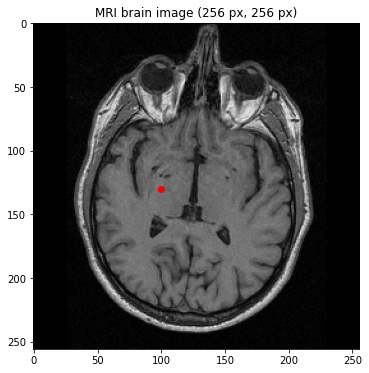

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
# ax.axis('off')
plt.scatter(100, 130, color='r')
plt.show()

### 1.2 Region growing (5pts)

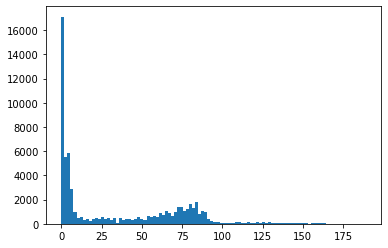

In [3]:
plt.hist(brain_im.flatten(), bins=100)
plt.show()

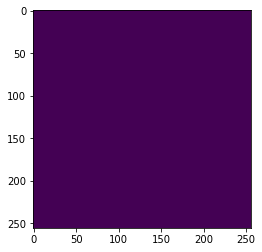

In [4]:
import numpy as np

img_mask = -1*np.ones(brain_im.shape)
plt.imshow(img_mask)
plt.show()

In [43]:
# Add your implementation and discussion


def similar(p_1, p_2):
    thresh = 8
    value = np.abs(int(p_1) - int(p_2))
#     print(value)
    return value < thresh

    
def region_growing(img, curr_pix, criterion):
    global img_mask
    for i in range(-1,2): #img[curr_pix[0]-1:curr_pix[0]+2, curr_pix[1]-1:curr_pix[1]+2]:
        for j in range(-1,2):
            if (i!=0 or j!=0) and 0 <= curr_pix[0] + i < img.shape[1] and 0 < curr_pix[1] + j < img.shape[0]:
#                 print(curr_pix[0]+i, curr_pix[1]+j)
                if img_mask[curr_pix[0]+i, curr_pix[1]+j] == -1:
#                     print("foo")
                    if criterion(img[curr_pix], img[curr_pix[0]+i, curr_pix[1]+j]):
                        img_mask[curr_pix[0]+i, curr_pix[1]+j] = 1
#                         print("recursion time !")
                        region_growing(img, (curr_pix[0]+i, curr_pix[1]+j), criterion)
                    else:
                        img_mask[curr_pix[0]+i, curr_pix[1]+j] = 0              


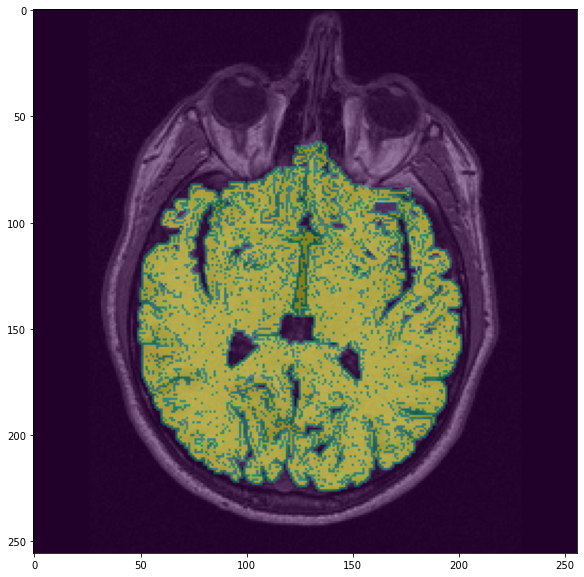

In [44]:
# hack to make it work on windows too
import sys
import threading
sys.setrecursionlimit(256*256)
threading.stack_size(1024*1024*64) #64 MB


plt.figure(figsize=(10,10))
init_pix = (130,100)
img_mask = -1*np.ones(brain_im.shape)
thread = threading.Thread(target=region_growing, args=(brain_im, init_pix, similar))
thread.start()
plt.imshow(brain_im, cmap='gray')
plt.imshow(img_mask, alpha=0.5)
plt.show()

Let's print the number of the mask's pixels. This is our estimation of the brain's size in pixels

In [8]:
print(f'The brain has {(img_mask == 1).sum()} pixels')

The brain has 12620 pixels


#### Discussion:
The region growing method on the non-thresholded image gave us a reasonable estimate, although we can see that some non-brain regions that are similar to the brain are included in the mask

### 1.3 Contour detection (5pts)


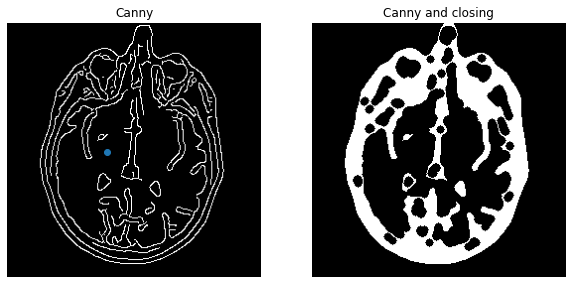

In [64]:
from skimage.feature import canny
from skimage.morphology import binary_closing, dilation
edges = canny(brain_im, sigma=1.7)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Canny')
plt.imshow(edges, cmap='gray')
plt.scatter(x=init_pix[1], y=init_pix[0])
plt.axis('off')

edges = binary_closing(edges, selem=skimage.morphology.disk(4))
plt.subplot(1,2,2)
plt.title('Canny and closing')
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

Note that we closed the detected edges to be able to do the next step, which is to use region growing inside the brain border to find the number of pixels inside the brain

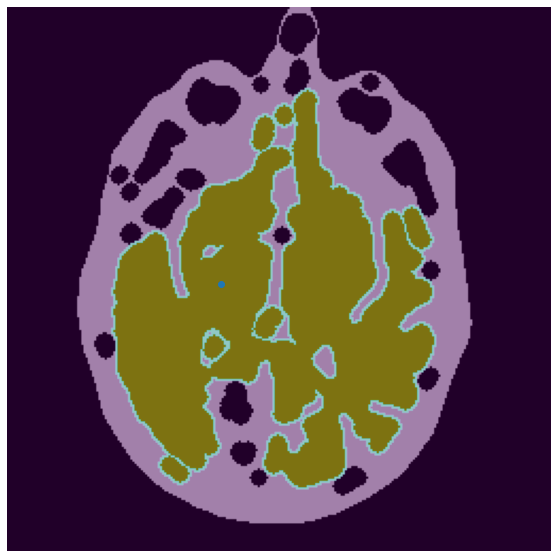

In [66]:
img_mask = -1*np.ones_like(edges)
thread = threading.Thread(target=region_growing, args=(edges, init_pix, lambda x,y:  x== y))
thread.start()
plt.figure(figsize=(10,10))
plt.imshow(edges, cmap='gray')
plt.scatter(init_pix[1], init_pix[0])
plt.imshow(img_mask, alpha=0.5)
plt.axis('off')
plt.show()

In [67]:
print(f'Using the contour detection method, the brain has {(img_mask == 1).sum()} pixels')

Using the contour detection method, the brain has 14546 pixels


We note having a bigger estimate using this method, this makes sense since we see some regions of the skull being included in the mask, the closure wasn't perfect

### 1.4 Additional method (5pts)
Thersholding then region growing?

In [14]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [15]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


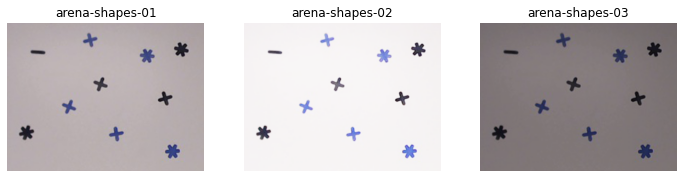

In [16]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [17]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [18]:
# Add your implementation and discussion